# Laboratorium 8. (PageRank)

## 1. Prosty ranking wierzchołków

In [1]:
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

### 1.1. Implementacja modelu błądzenia przypadkowego

In [2]:
def random_walk(A, d=0.85, max_iter=100, tol=1e-6):
    n = A.shape[0]
    r = np.ones(n) / n

    for i in range(max_iter):
        r_next = d * (A @ r) + (1 - d) * np.ones(n) / n
        if np.linalg.norm(r_next - r, 1) < tol:
            return r_next, i + 1
        r = r_next

    return r, max_iter

### 1.2. Funkcje pomocnicze

In [3]:
def generate_random_directed_graph(n, p=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)

    graph = [[] for _ in range(n)]

    for u in range(n):
        for v in range(n):
            if u != v and np.random.random() < p:
                graph[u].append(v)

    return graph


def create_adj_matrix(graph):
    n = len(graph)
    A = np.zeros((n, n))

    for u in range(n):
        outgoing_edges = graph[u]
        Nu = len(outgoing_edges)
        if Nu > 0:
            for v in outgoing_edges:
                A[v, u] = 1 / Nu

    return A

### 1.3. Funkcje odpowiadające za wizualizację wyników

In [4]:
def display_results(results):
    rows = []
    for graph_name, graph_results in results.items():
        for d, d_results in graph_results.items():
            top5 = [int(node) for node in d_results["top5"]]
            top5_vals = [f"{float(v):.4f}" for v in d_results["pr"][d_results["top5"]]]

            row = {
                "Graph": graph_name,
                "Vertices": d_results["vertices"],
                "Edges": d_results["edges"],
                "Damping factor": d,
                "Iterations": d_results["iterations"],
                "Time": f"{d_results['time']:.6f}s",
                "Top 5 nodes": str(top5),
                "Ranking values": str(top5_vals).replace("'", ""),
            }
            rows.append(row)

    df = pd.DataFrame(rows)
    display(df)


def visualize_results(results):
    for graph_name, graph_results in results.items():
        for d, d_results in graph_results.items():
            G = d_results["G"]
            pr = d_results["pr"]

            _, axes = plt.subplots(1, 2, figsize=(14, 6))

            pos = nx.kamada_kawai_layout(G)
            nx.draw_networkx(
                G,
                pos,
                ax=axes[0],
                node_size=[v * 3000 for v in pr],
                node_color=pr,
                cmap=plt.cm.viridis,
                with_labels=True,
                arrows=True,
            )
            axes[0].set_title(f"Random walk for {graph_name} (d={d})")
            axes[0].axis("off")

            axes[1].hist(pr, bins=30, color="skyblue", edgecolor="black")
            axes[1].set_title(f"Ranking histogram: {graph_name} (d={d})")
            axes[1].set_xlabel("Ranking value")
            axes[1].set_ylabel("Number of nodes")
            axes[1].grid(True)

            plt.tight_layout()
            plt.show()

### 1.4. Funkcja testująca

In [5]:
def test_all(graph, d=0.85):
    adjacency_matrix = create_adj_matrix(graph)

    start_time = time.time()
    ranking_scores, iterations = random_walk(adjacency_matrix, d=d)
    computation_time = time.time() - start_time

    G = nx.DiGraph()
    for node, neighbors in enumerate(graph):
        G.add_node(node)
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    top5_indices = np.argsort(ranking_scores)[-5:][::-1]

    result = {
        "pr": ranking_scores,
        "iterations": iterations,
        "time": computation_time,
        "top5": top5_indices,
        "G": G,
    }

    return result

### 1.5. Wyniki

,Graph,Vertices,Edges,Damping factor,Iterations,Time,Top 5 nodes,Ranking values
0,15-node graph,15,37,0.85,24,0.000402s,"[10, 9, 14, 4, 0]","[0.1155, 0.1090, 0.1040, 0.0977, 0.0967]"
1,25-node graph,25,81,0.85,54,0.000543s,"[6, 1, 23, 12, 13]","[0.1079, 0.1059, 0.0813, 0.0612, 0.0598]"
2,40-node graph,40,151,0.85,19,0.000253s,"[34, 22, 20, 30, 7]","[0.0594, 0.0437, 0.0433, 0.0415, 0.0412]"


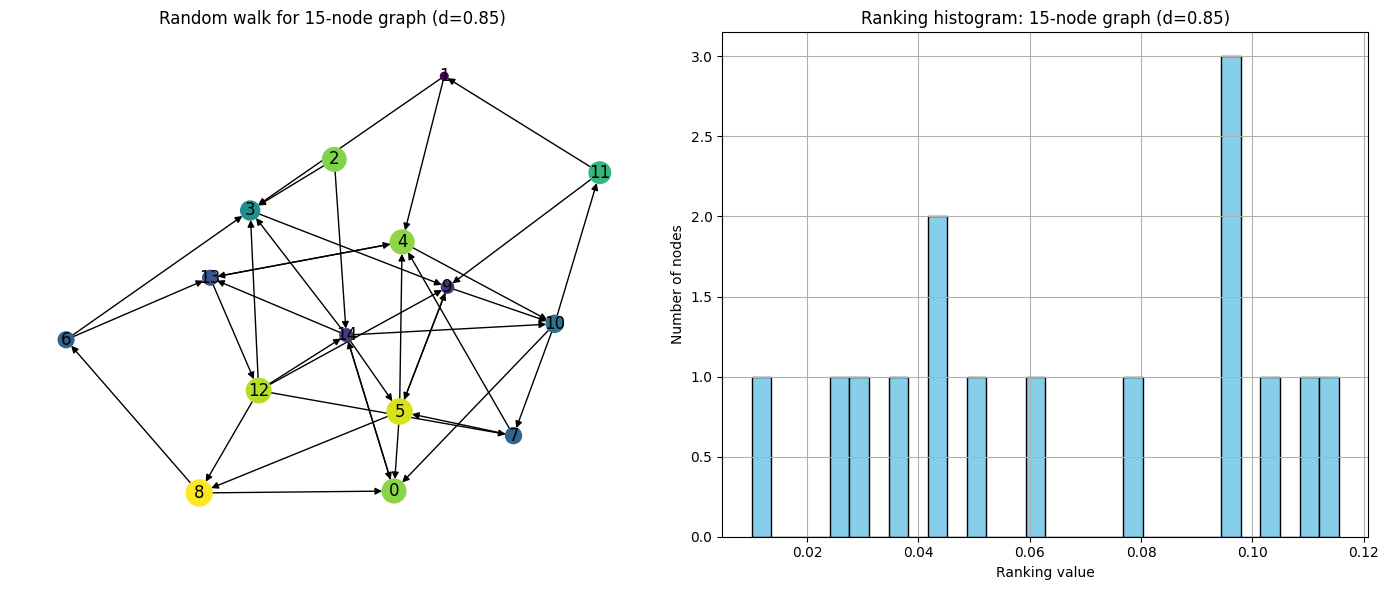

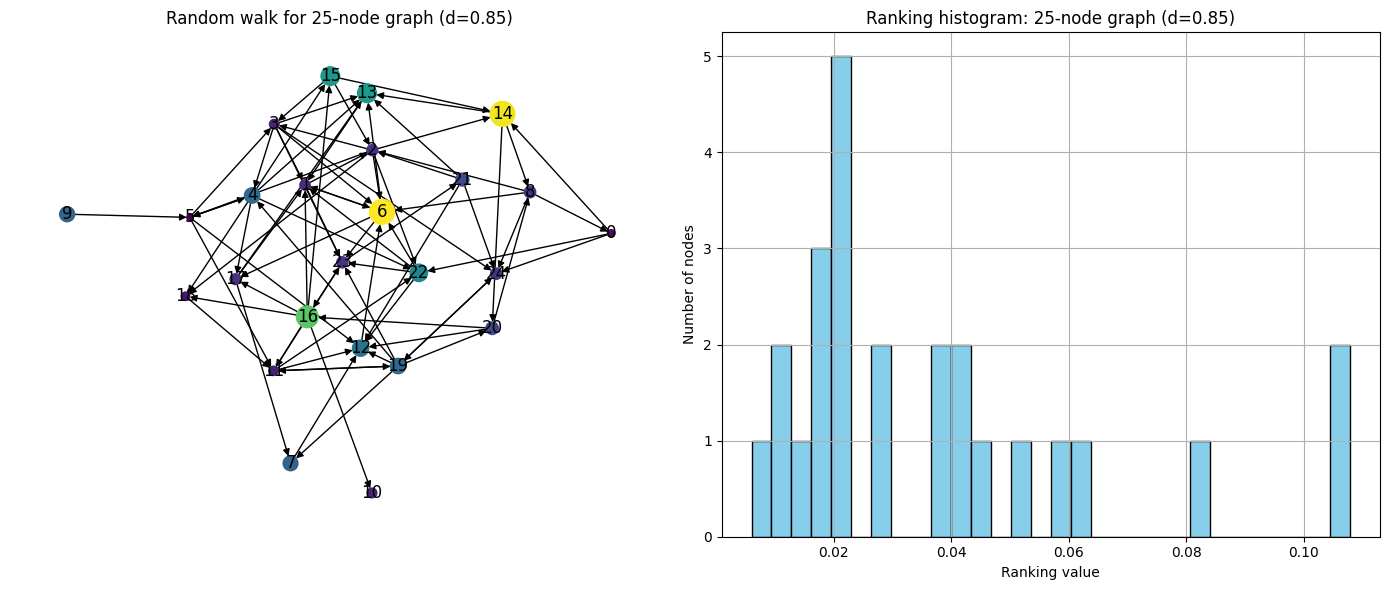

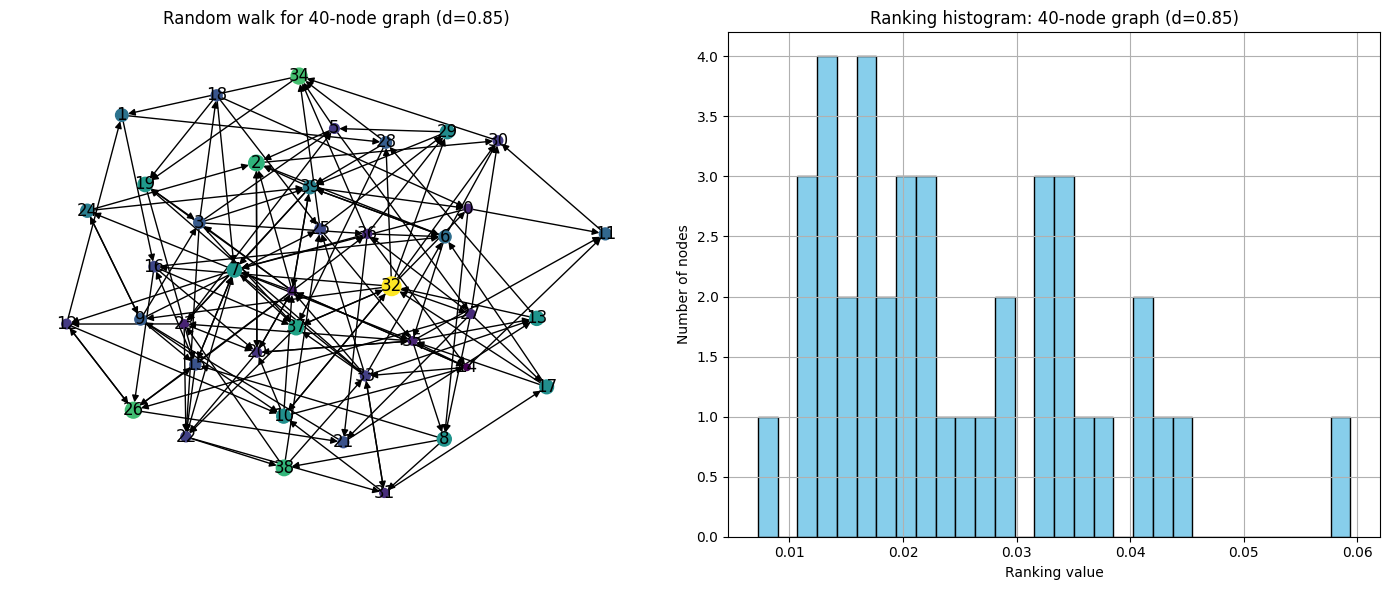

In [6]:
graphs = {
    "15-node graph": generate_random_directed_graph(15, p=0.2, seed=123),
    "25-node graph": generate_random_directed_graph(25, p=0.15, seed=456),
    "40-node graph": generate_random_directed_graph(40, p=0.1, seed=789),
}

damping_factors = [0.85]

results = {}

for graph_name, graph in graphs.items():
    results[graph_name] = {}

    for d in damping_factors:
        result = test_all(graph, d)

        edge_count = sum(len(neighbors) for neighbors in graph)

        results[graph_name][d] = result
        results[graph_name][d]["vertices"] = len(graph)
        results[graph_name][d]["edges"] = edge_count

display_results(results)

visualize_results(results)

## 2. Page Rank

In [7]:
import gzip
import os
import shutil
import time
import urllib.request

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

### 2.1. Implementacja algorytmu PageRank ze skokami

In [8]:
def pagerank(A, e=None, d=0.85, max_iter=100, tol=1e-6):
    n = A.shape[0]

    if e is None:
        e = np.ones(n) / n

    r = np.ones(n) / n

    for i in range(max_iter):
        r_next = d * A @ r

        delta_norm = np.linalg.norm(r, 1) - np.linalg.norm(r_next, 1)
        r_next = r_next + delta_norm * e

        delta = np.linalg.norm(r_next - r, 1)

        if delta < tol:
            return r_next, i + 1

        r = r_next

    return r, max_iter

### 2.2. Funkcje pomocnicze

In [9]:
def create_adj_matrix(G):
    n = G.number_of_nodes()
    A = np.zeros((n, n))

    for u in G.nodes():
        out_degree = G.out_degree(u)
        if out_degree > 0:
            for v in G.successors(u):
                A[v, u] = 1.0 / out_degree

    return A


def create_adj_matrix_sparse(G):
    n = G.number_of_nodes()
    node_to_index = {node: i for i, node in enumerate(G.nodes())}
    rows, cols, data = [], [], []

    for u in G.nodes():
        out_degree = G.out_degree(u)
        if out_degree > 0:
            for v in G.successors(u):
                rows.append(node_to_index[v])
                cols.append(node_to_index[u])
                data.append(1.0 / out_degree)

    return csr_matrix((data, (rows, cols)), shape=(n, n))


def download_and_extract(url, output_file):
    if not os.path.exists(output_file):
        gz_file = f"{output_file}.gz"
        if not os.path.exists(gz_file):
            print(f"Downloading {url}...")
            urllib.request.urlretrieve(url, gz_file)

        print(f"Extracting {gz_file}...")
        with gzip.open(gz_file, "rb") as f_in:
            with open(output_file, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

    return output_file

### 2.3. Funkcje odpowiadające za wizualizację wyników

In [10]:
def display_results(results):
    rows = []
    for d, d_results in results.items():
        for name, result in d_results.items():
            top5 = [int(node) for node in result["top5"]]
            top5_vals = [f"{float(v):.3f}" for v in result["pr"][result["top5"]]]

            row = {
                "Damping factor": d,
                "Jump vector": name,
                "Iterations": result["iterations"],
                "Time": f"{result['time']:.6f}s",
                "Top 5 nodes": str(top5),
                "PageRank values": str(top5_vals).replace("'", ""),
            }
            rows.append(row)

    display(pd.DataFrame(rows))


def visualize_pagerank_comparison(G, results, d=0.85):
    jump_vectors = list(results[d].keys())
    num_vectors = len(jump_vectors)

    plt.figure(figsize=(4 * num_vectors, 6))
    pos = nx.spring_layout(G, seed=42)

    for i, name in enumerate(jump_vectors):
        plt.subplot(1, num_vectors, i + 1)
        pr = results[d][name]["pr"]
        nx.draw_networkx(
            G,
            pos,
            node_size=[v * 5000 for v in pr],
            node_color=pr,
            cmap=plt.cm.viridis,
            with_labels=True,
            arrows=True,
        )
        plt.title(f"PageRank with {name} (d={d})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


def plot_pagerank_histogram(pr, title):
    plt.figure(figsize=(8, 4))
    plt.hist(pr, bins=50, color="skyblue", edgecolor="black")
    plt.title(f"PageRank histogram: {title}")
    plt.xlabel("PageRank value")
    plt.ylabel("Number of nodes")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_pagerank_histogram_large(pr, title):
    plt.figure(figsize=(10, 6))

    upper_limit = np.percentile(pr, 95)

    plt.hist(
        pr,
        bins=np.linspace(min(pr), upper_limit, 100),
        color="skyblue",
        edgecolor="black",
    )
    plt.xlabel("PageRank value")
    plt.ylabel("Number of nodes")
    plt.title(f"PageRank histogram (Zoomed in): {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 2.4. Funkcje testujące

In [11]:
def test_jump_vectors(A, damping_factors, jump_vectors):
    results = {}

    for d in damping_factors:
        d_results = {}
        for name, e in jump_vectors.items():
            start_time = time.time()
            pr, iterations = pagerank(A, e=e, d=d)
            end_time = time.time()

            d_results[name] = {
                "pr": pr,
                "iterations": iterations,
                "time": end_time - start_time,
                "top5": np.argsort(-pr)[:5],
            }
        results[d] = d_results

    return results
    

def test_karate_club(damping_factors):
    G = nx.karate_club_graph()
    G = G.to_directed()

    print(
        f"Karate Club graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges"
    )

    n = G.number_of_nodes()

    jump_vectors = {
        "uniform": np.ones(n) / n,
        "first_biased": np.array([0.5] + [0.5 / (n - 1)] * (n - 1)),
        "half_biased": np.array(
            [0.7 / (n // 2)] * (n // 2) + [0.3 / (n - n // 2)] * (n - n // 2)
        ),
    }

    A = create_adj_matrix(G)
    results = test_jump_vectors(A, damping_factors, jump_vectors)

    print("\nResults for Karate Club graph:")
    display_results(results)

    return G, results


def test_epinions(url, file_path, damping_factors):
    file_path = download_and_extract(url, file_path)

    print(f"Loading graph from {file_path}...")
    G = nx.read_edgelist(file_path, create_using=nx.DiGraph(), comments="#")

    print(f"Epinions graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    n = G.number_of_nodes()

    jump_vectors = {
        "uniform": np.ones(n) / n,
        "first_biased": np.array([0.5] + [0.5 / (n - 1)] * (n - 1)),
        "half_biased": np.array(
            [0.7 / (n // 2)] * (n // 2) + [0.3 / (n - n // 2)] * (n - n // 2)
        ),
    }

    A_sparse = create_adj_matrix_sparse(G)
    results = test_jump_vectors(A_sparse, damping_factors, jump_vectors)

    print("\nResults for Epinions graph:")
    display_results(results)

    return results

### 2.5. Wyniki

Testing PageRank with jumps on Karate Club graph

Karate Club graph: 34 nodes, 156 edges

Results for Karate Club graph:


,Damping factor,Jump vector,Iterations,Time,Top 5 nodes,PageRank values
0,0.90,uniform,36,0.001106s,"[33, 0, 32, 2, 1]","[0.103, 0.099, 0.073, 0.059, 0.054]"
1,0.90,first_biased,43,0.001066s,"[0, 33, 1, 2, 32]","[0.157, 0.084, 0.060, 0.059, 0.058]"
2,0.90,half_biased,41,0.000628s,"[0, 33, 32, 2, 1]","[0.110, 0.094, 0.066, 0.061, 0.057]"
3,0.85,uniform,30,0.000448s,"[33, 0, 32, 2, 1]","[0.101, 0.097, 0.072, 0.057, 0.053]"
4,0.85,first_biased,37,0.001292s,"[0, 33, 1, 2, 32]","[0.179, 0.077, 0.059, 0.056, 0.053]"
5,0.85,half_biased,35,0.000552s,"[0, 33, 32, 2, 1]","[0.110, 0.089, 0.063, 0.060, 0.056]"
6,0.75,uniform,23,0.000406s,"[33, 0, 32, 2, 1]","[0.096, 0.092, 0.068, 0.053, 0.050]"
7,0.75,first_biased,28,0.000420s,"[0, 33, 1, 2, 32]","[0.219, 0.066, 0.055, 0.051, 0.046]"
8,0.75,half_biased,27,0.000415s,"[0, 33, 2, 32, 1]","[0.107, 0.082, 0.058, 0.058, 0.054]"
9,0.60,uniform,17,0.000304s,"[33, 0, 32, 2, 1]","[0.087, 0.083, 0.063, 0.048, 0.047]"


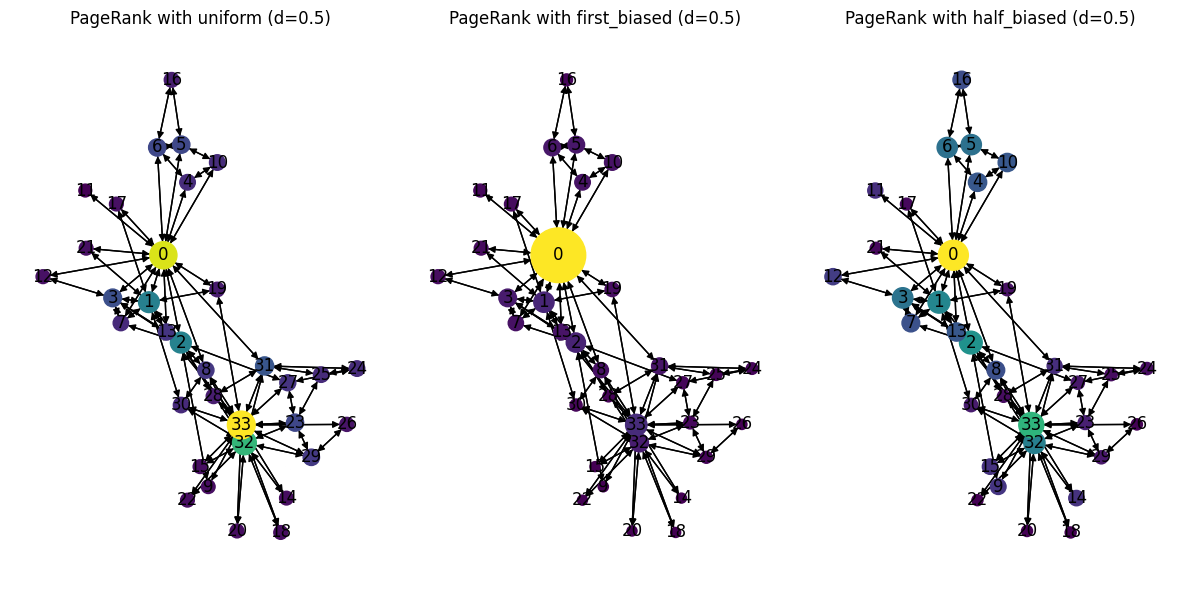

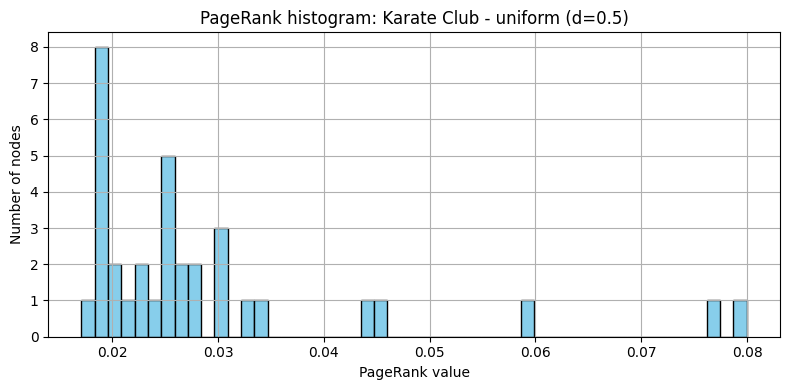

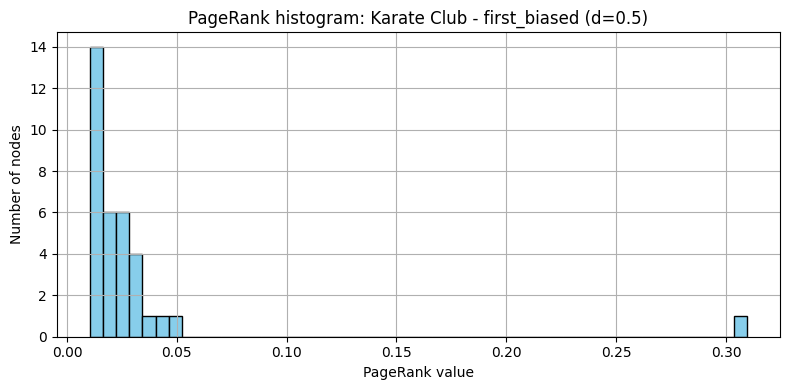

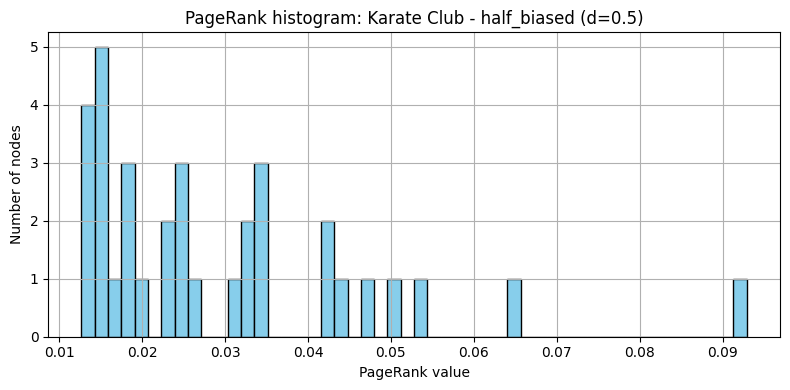


Testing PageRank with jumps on Epinions graph (~75k nodes)

Loading graph from c:\Users\kuba2\!studia\Mownit\computational-methods-course\lab8\ex2\test_graphs\soc-Epinions1.txt...
Epinions graph: 75879 nodes, 508837 edges

Results for Epinions graph:


,Damping factor,Jump vector,Iterations,Time,Top 5 nodes,PageRank values
0,0.90,uniform,83,0.290626s,"[14, 185, 114, 529, 36]","[0.005, 0.004, 0.002, 0.002, 0.002]"
1,0.90,first_biased,84,0.270406s,"[0, 14, 185, 36, 114]","[0.065, 0.005, 0.004, 0.003, 0.003]"
2,0.90,half_biased,84,0.242836s,"[14, 185, 114, 529, 36]","[0.005, 0.004, 0.002, 0.002, 0.002]"
3,0.85,uniform,54,0.166368s,"[14, 185, 114, 529, 132]","[0.005, 0.003, 0.002, 0.002, 0.002]"
4,0.85,first_biased,55,0.161552s,"[0, 14, 185, 36, 114]","[0.092, 0.005, 0.003, 0.003, 0.003]"
5,0.85,half_biased,55,0.165666s,"[14, 185, 114, 529, 132]","[0.005, 0.003, 0.002, 0.002, 0.002]"
6,0.75,uniform,31,0.083948s,"[14, 185, 529, 230, 114]","[0.004, 0.002, 0.002, 0.002, 0.002]"
7,0.75,first_biased,33,0.095533s,"[0, 14, 23, 114, 36]","[0.144, 0.004, 0.002, 0.002, 0.002]"
8,0.75,half_biased,32,0.093544s,"[14, 185, 529, 230, 530]","[0.004, 0.002, 0.002, 0.002, 0.002]"
9,0.60,uniform,18,0.053902s,"[14, 185, 230, 529, 530]","[0.003, 0.002, 0.001, 0.001, 0.001]"


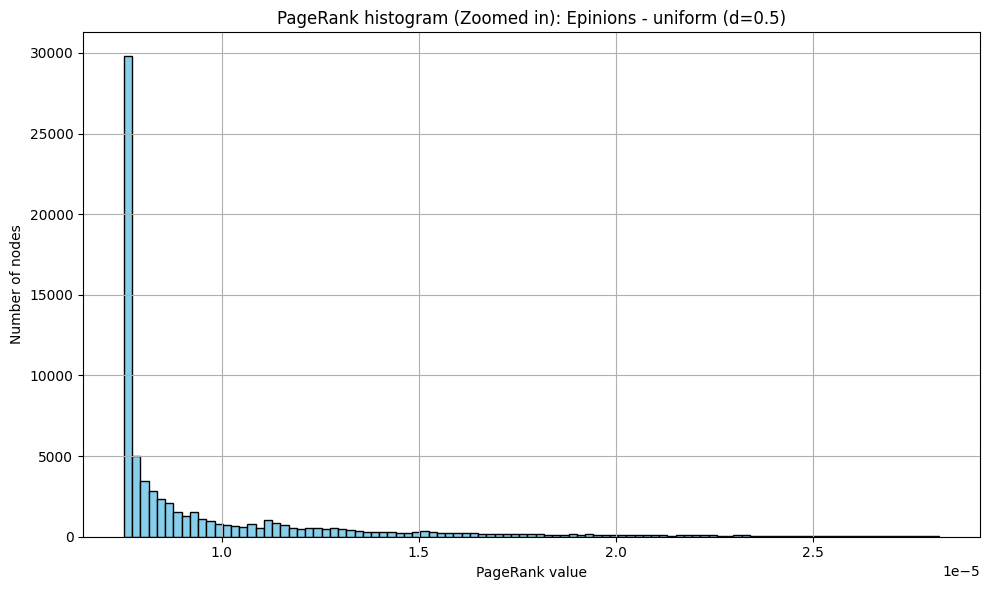

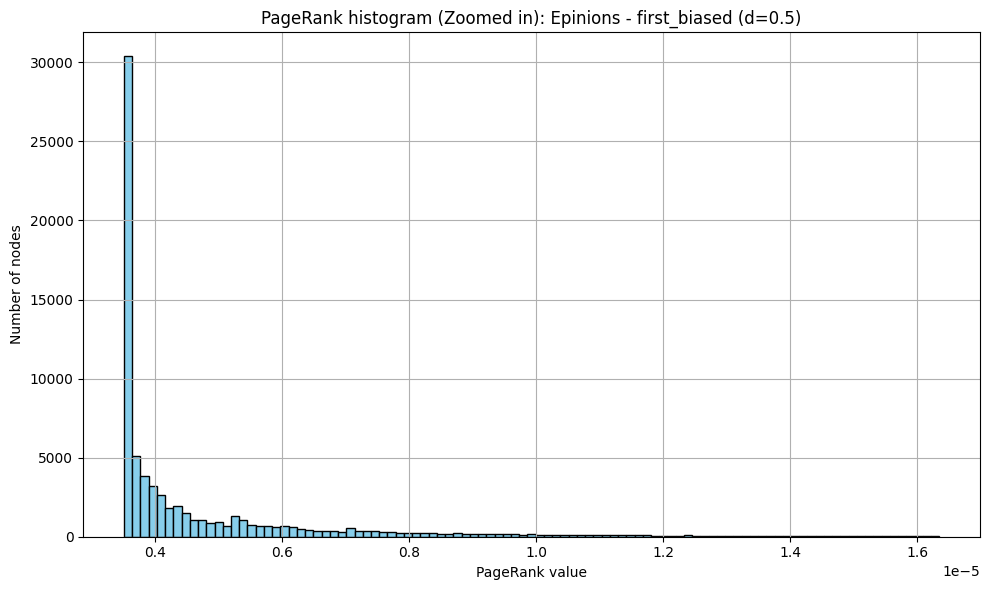

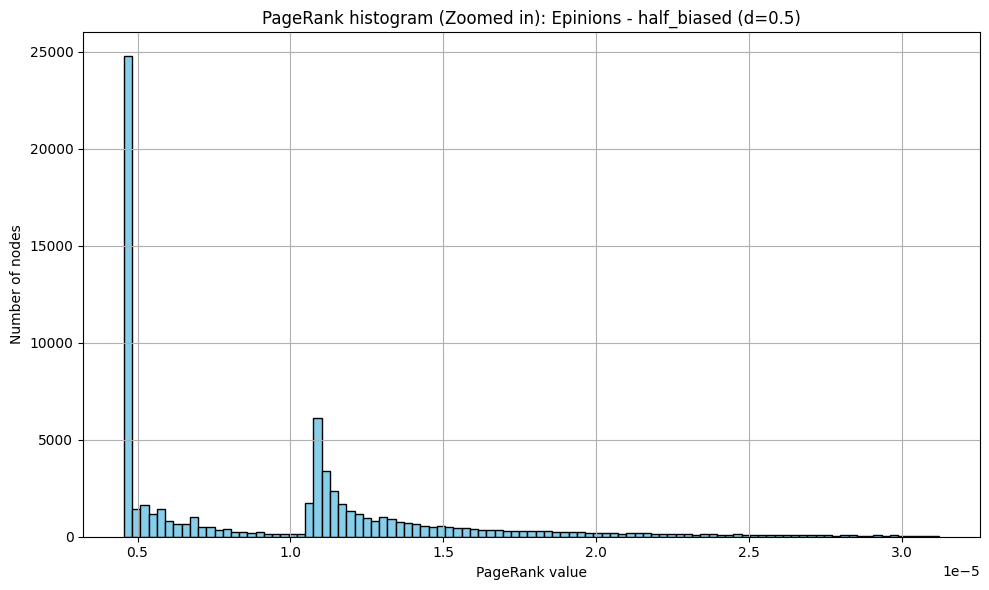

In [12]:
damping_factors = [0.9, 0.85, 0.75, 0.6, 0.5]

print("Testing PageRank with jumps on Karate Club graph\n")
graph, results_karate = test_karate_club(damping_factors)

visualize_pagerank_comparison(graph, results_karate, 0.5)

for name in results_karate[0.5]:
    pr = results_karate[0.5][name]["pr"]
    plot_pagerank_histogram(pr, f"Karate Club - {name} (d=0.5)")

print("\nTesting PageRank with jumps on Epinions graph (~75k nodes)\n")

large_graph_url = "https://snap.stanford.edu/data/soc-Epinions1.txt.gz"
directory = os.path.join(os.getcwd(), "ex2", "test_graphs")
os.makedirs(directory, exist_ok=True)
large_graph_file = os.path.join(directory, "soc-Epinions1.txt")

results_large = test_epinions(large_graph_url, large_graph_file, damping_factors)

for name in results_large[0.5]:
    pr = results_large[0.5][name]["pr"]
    plot_pagerank_histogram_large(pr, f"Epinions - {name} (d=0.5)")